<a href="https://colab.research.google.com/github/felicityogoke/HealthCare-Sentiment-Analysis/blob/main/Sentiment_analysis_evaluation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import tensorflow as tf

In [ ]:
# # Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


##Exploratory Analysis

In [ ]:
# Load Tweet dataset# Load dataset file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/webmd.csv")
# Output first five rows
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [ ]:
df.shape

(362806, 12)

In [ ]:
# Map the numerical ratings to corresponding labels
label_map = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['sentiment'] = df['Satisfaction'].map(label_map)

In [ ]:
# create a new dataframe with only the reviews column and sentiment column
df = df.loc[:, ['Reviews', 'sentiment']]

In [ ]:
df.head()

,Reviews,sentiment
0,I'm a retired physician and of all the meds I ...,Positive
1,cleared me right up even with my throat hurtin...,Positive
2,why did my PTINR go from a normal of 2.5 to ov...,Neutral
3,FALLING AND DON'T REALISE IT,Negative
4,My grandfather was prescribed this medication ...,Negative


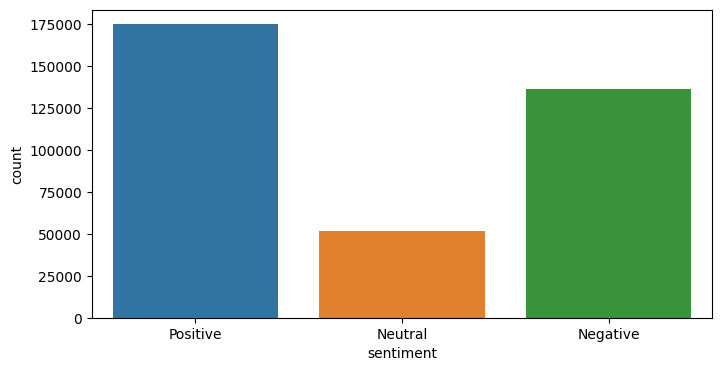

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df);

In [ ]:
# Drop all rows with a rating of 3
df = df.loc[df['sentiment'] != 'Neutral']


In [ ]:
df['Reviews'].apply(lambda x:len(str(x).split())).max()

534

In [ ]:
#print the number of null values in each column
df.isnull().sum()

Reviews      31
sentiment     3
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
# Split the data into training and testing sets (70% for training and 30% for testing)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Split the training data into training and validation sets (50% for training and 50% for validation)
df_train, df_val = train_test_split(df_train, test_size=0.5, random_state=42)


In [ ]:
df_train.shape

(108822, 2)

In [ ]:
df_val.shape

(108822, 2)

In [ ]:
df_test.shape

(93276, 2)

In [ ]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Reviews'].duplicated() == True]

,Reviews,sentiment
14,,Negative
877,good,Positive
2582,not good,Positive
6218,cough,Positive
7762,\n,Negative
11209,dizziness,Negative
12181,muscle pain,Positive
12486,still pain,Positive
14347,none,Positive
16779,back pain,Negative


In [ ]:
#print some of those rows to check
df_train[df_train['Reviews'] == df_train.iloc[33083]['Reviews']]

,Reviews,sentiment
26806,dry mouth,Negative
33083,dry mouth,Positive


In [ ]:
#removing duplicated text 
index = df_train[df_train['Reviews'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
df_train.shape

(87094, 2)

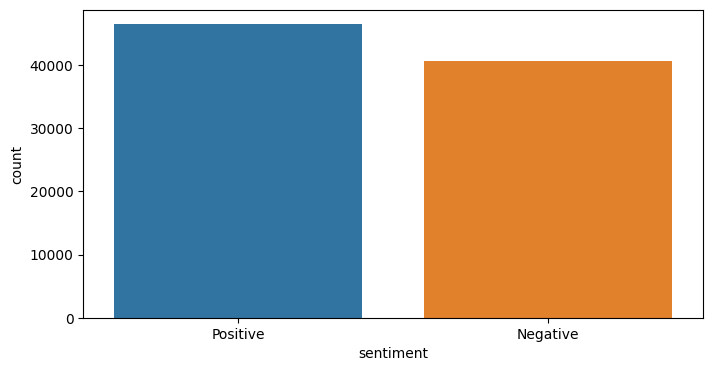

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_train);

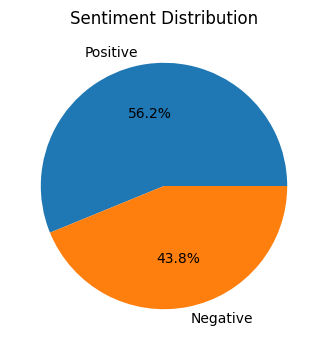

In [ ]:

# count the number of positive and negative sentiments
pos_count = df[df['sentiment']=='Positive'].count()['sentiment']
neg_count = df[df['sentiment']=='Negative'].count()['sentiment']

# create a pie chart
plt.figure(figsize=(4,4))
plt.pie([pos_count, neg_count], labels=['Positive', 'Negative'], autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()


In [ ]:
df_train = df_train.loc[:12000,:]
df_train.shape

(12001, 2)

In [ ]:
#We will check the maximum number of words that can be present in a comment , this will help us in padding later
df_train['Reviews'].apply(lambda x:len(str(x).split())).max()

422

In [ ]:
#a function for getting auc score for validation

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_train.Reviews.values, df_train.sentiment.values, 
                                                  stratify=df_train.sentiment.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
yvalid = le.fit_transform(yvalid)

In [ ]:
print(ytrain)

[0 1 1 ... 1 1 0]


In [ ]:
xtrain.shape, ytrain.shape

((9600,), (9600,))

##SIMPLE RNN

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
%%time
    # A simpleRNN without any pretrained embeddings and one dense layer
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
rnn_model.add(SimpleRNN(100))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          6336000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6,376,201
Trainable params: 6,376,201
Non-trainable params: 0
_________________________________________________________________
CPU times: user 167 ms, sys: 13.1 ms, total: 180 ms
Wall time: 182 ms


In [ ]:
rnn_history = rnn_model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64,validation_data=(xvalid_pad, yvalid)) 

Epoch 1/5
150/150 [==============================] - 105s 685ms/step - loss: 0.6620 - accuracy: 0.5906 - val_loss: 0.6119 - val_accuracy: 0.6389
Epoch 2/5
150/150 [==============================] - 86s 575ms/step - loss: 0.5419 - accuracy: 0.7432 - val_loss: 0.5514 - val_accuracy: 0.7164
Epoch 3/5
150/150 [==============================] - 76s 501ms/step - loss: 0.3821 - accuracy: 0.8331 - val_loss: 0.5508 - val_accuracy: 0.7343
Epoch 4/5
150/150 [==============================] - 73s 490ms/step - loss: 0.2522 - accuracy: 0.8995 - val_loss: 0.6087 - val_accuracy: 0.7551
Epoch 5/5
150/150 [==============================] - 74s 489ms/step - loss: 0.1722 - accuracy: 0.9364 - val_loss: 0.8633 - val_accuracy: 0.7259


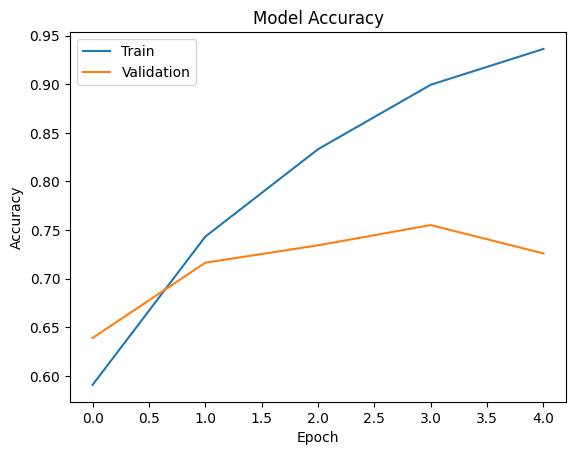

In [ ]:
# Plot the training and validation accuracy over time
train_acc = rnn_history.history['accuracy']
val_acc = rnn_history.history['val_accuracy']
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
scores_rnn = rnn_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_rnn,yvalid)))

76/76 [==============================] - 4s 50ms/step
Auc: 0.82%


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

In [ ]:
# Assume X_test is the test data and y_test is the corresponding labels
y_pred = rnn_model.predict(xvalid_pad)

y_pred = np.round(y_pred) # Convert probabilities to class labels

accuracy = accuracy_score(yvalid, y_pred)
precision = precision_score(yvalid, y_pred, average='weighted')
recall = recall_score(yvalid, y_pred, average='weighted')
f1 = f1_score(yvalid, y_pred, average='weighted')
auc_score = roc_auc_score(yvalid, y_pred,average='weighted')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("AUC score: ", auc_score)

76/76 [==============================] - 4s 55ms/step
Accuracy:  0.7259475218658892
Precision:  0.7481935605916261
Recall:  0.7259475218658892
F1 Score:  0.723564924254752
AUC score:  0.7339885987444116


In [ ]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores_rnn,yvalid)})

##LSTM MODEL


In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:27, 10563.09it/s]

Found 2196016 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 21119/21119 [00:00<00:00, 273615.64it/s]


In [ ]:
%%time

    
# A simple LSTM with glove embeddings and one dense layer
lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

lstm_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          6336000   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,496,501
Trainable params: 160,501
Non-trainable params: 6,336,000
_________________________________________________________________
CPU times: user 215 ms, sys: 47 ms, total: 262 ms
Wall time: 269 ms


In [ ]:
lstm_history = lstm_model.fit(xtrain_pad, ytrain, epochs=8, batch_size=64,validation_data=(xvalid_pad, yvalid))

Epoch 1/8
150/150 [==============================] - 134s 877ms/step - loss: 0.6208 - accuracy: 0.6551 - val_loss: 0.5558 - val_accuracy: 0.7185
Epoch 2/8
150/150 [==============================] - 135s 902ms/step - loss: 0.5532 - accuracy: 0.7207 - val_loss: 0.5708 - val_accuracy: 0.6935
Epoch 3/8
150/150 [==============================] - 136s 907ms/step - loss: 0.5223 - accuracy: 0.7443 - val_loss: 0.5127 - val_accuracy: 0.7443
Epoch 4/8
150/150 [==============================] - 136s 906ms/step - loss: 0.4934 - accuracy: 0.7622 - val_loss: 0.4789 - val_accuracy: 0.7730
Epoch 5/8
150/150 [==============================] - 136s 908ms/step - loss: 0.4627 - accuracy: 0.7768 - val_loss: 0.4650 - val_accuracy: 0.7768
Epoch 6/8
150/150 [==============================] - 135s 904ms/step - loss: 0.4334 - accuracy: 0.7958 - val_loss: 0.4575 - val_accuracy: 0.7751
Epoch 7/8
150/150 [==============================] - 135s 903ms/step - loss: 0.4116 - accuracy: 0.8081 - val_loss: 0.4472 - val_ac

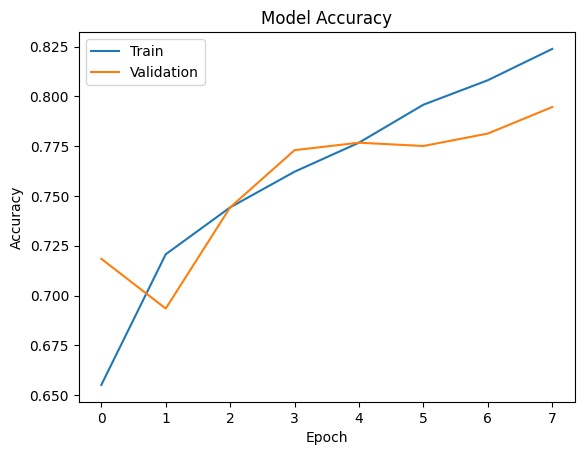

In [ ]:
# Plot the training and validation accuracy over time
train_acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

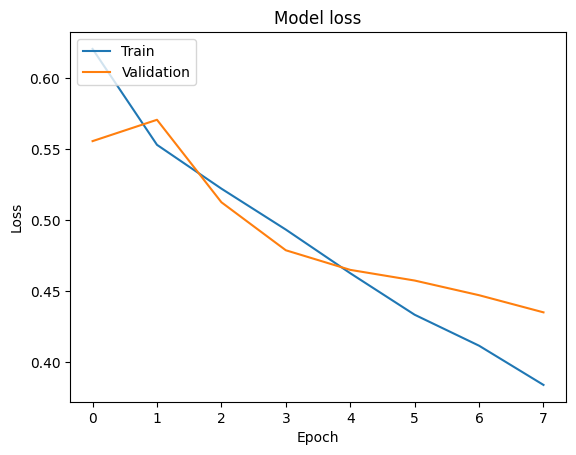

In [ ]:
# Plot the training and validation accuracy over time
train_acc = lstm_history.history['loss']
val_acc = lstm_history.history['val_loss']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
scores_lstm = lstm_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_lstm,yvalid)))

76/76 [==============================] - 12s 159ms/step
Auc: 0.88%


In [ ]:
# Assume X_test is the test data and y_test is the corresponding labels
y_pred = lstm_model.predict(xvalid_pad)

y_pred = np.round(y_pred) # Convert probabilities to binary class labels

accuracy = accuracy_score(yvalid, y_pred)
precision = precision_score(yvalid, y_pred, average='weighted')
recall = recall_score(yvalid, y_pred, average='weighted')
f1 = f1_score(yvalid, y_pred, average='weighted')
auc_score = roc_auc_score(yvalid, y_pred,average='weighted')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("AUC score: ", auc_score)


76/76 [==============================] - 13s 170ms/step
Accuracy:  0.7946688879633486
Precision:  0.7958745075642619
Recall:  0.7946688879633486
F1 Score:  0.7948845786167914
AUC score:  0.7952135225361657


In [ ]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores_lstm,yvalid)})

##GRU 

In [ ]:
%%time

# GRU with glove embeddings and two dense layers
gru_model = Sequential()
gru_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(GRU(300))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 300)          6336000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 500, 300)         0         
 lDropout1D)                                                     
                                                                 
 gru_2 (GRU)                 (None, 300)               541800    
                                                                 
 dense_4 (Dense)             (None, 1)                 301       
                                                                 
Total params: 6,878,101
Trainable params: 542,101
Non-trainable params: 6,336,000
_________________________________________________________________
CPU times: user 401 ms, sys: 7.47 ms, total: 409 ms
Wall time: 468 ms


In [ ]:
gru_history = gru_model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64,validation_data=(xvalid_pad, yvalid))

Epoch 1/5
150/150 [==============================] - 11s 63ms/step - loss: 0.6559 - accuracy: 0.6048 - val_loss: 0.5931 - val_accuracy: 0.6901
Epoch 2/5
150/150 [==============================] - 9s 61ms/step - loss: 0.5597 - accuracy: 0.7154 - val_loss: 0.4888 - val_accuracy: 0.7659
Epoch 3/5
150/150 [==============================] - 9s 61ms/step - loss: 0.4869 - accuracy: 0.7601 - val_loss: 0.4603 - val_accuracy: 0.7818
Epoch 4/5
150/150 [==============================] - 9s 62ms/step - loss: 0.4535 - accuracy: 0.7820 - val_loss: 0.4530 - val_accuracy: 0.7788
Epoch 5/5
150/150 [==============================] - 9s 58ms/step - loss: 0.4197 - accuracy: 0.8057 - val_loss: 0.4456 - val_accuracy: 0.7872


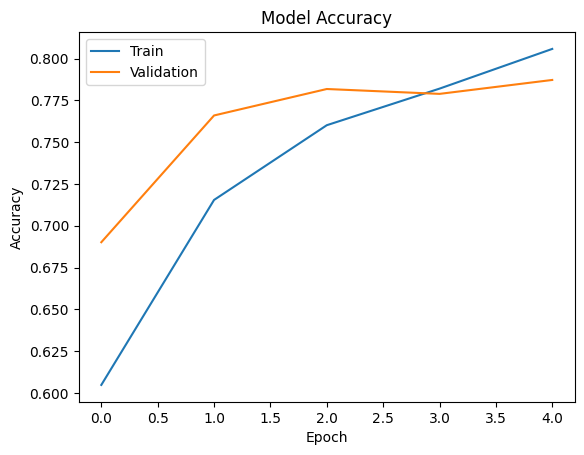

In [ ]:
# Plot the training and validation accuracy over time
train_acc = gru_history.history['accuracy']
val_acc = gru_history.history['val_accuracy']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

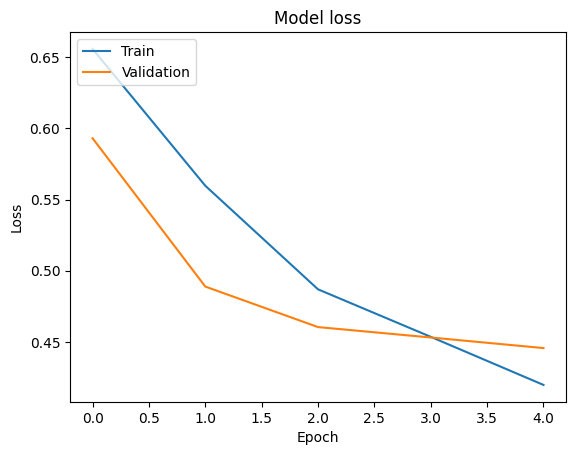

In [ ]:
# Plot the training and validation accuracy over time
train_acc = gru_history.history['loss']
val_acc = gru_history.history['val_loss']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
scores_gru = gru_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_gru,yvalid)))

76/76 [==============================] - 1s 14ms/step
Auc: 0.87%


In [ ]:
# Assume X_test is the test data and y_test is the corresponding labels
y_pred = gru_model.predict(xvalid_pad)

y_pred = np.round(y_pred) # Convert probabilities to class labels

accuracy = accuracy_score(yvalid, y_pred)
precision = precision_score(yvalid, y_pred, average='weighted')
recall = recall_score(yvalid, y_pred, average='weighted')
f1 = f1_score(yvalid, y_pred, average='weighted')
auc_score = roc_auc_score(yvalid, y_pred,average='weighted')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("AUC score: ", auc_score)

76/76 [==============================] - 1s 12ms/step
Accuracy:  0.7871720116618076
Precision:  0.7893029510925731
Recall:  0.7871720116618076
F1 Score:  0.7874282170751483
AUC score:  0.7883788351642835


In [ ]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores_gru,yvalid)})

##Bidirectional LSTM

In [ ]:
    # A simple bidirectional LSTM with glove embeddings and one dense layer
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
bi_lstm_model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

bi_lstm_model.add(Dense(1,activation='sigmoid'))
bi_lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
bi_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 300)          6336000   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 601       
                                                                 
Total params: 7,779,001
Trainable params: 1,443,001
Non-trainable params: 6,336,000
_________________________________________________________________


In [ ]:
bi_lstm_history= bi_lstm_model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64,validation_data=(xvalid_pad, yvalid))

Epoch 1/5
150/150 [==============================] - 258s 2s/step - loss: 0.6313 - accuracy: 0.6298 - val_loss: 0.5699 - val_accuracy: 0.7060
Epoch 2/5
150/150 [==============================] - 243s 2s/step - loss: 0.5659 - accuracy: 0.7064 - val_loss: 0.5681 - val_accuracy: 0.7264
Epoch 3/5
150/150 [==============================] - 253s 2s/step - loss: 0.5199 - accuracy: 0.7416 - val_loss: 0.5155 - val_accuracy: 0.7422
Epoch 4/5
150/150 [==============================] - 252s 2s/step - loss: 0.4828 - accuracy: 0.7664 - val_loss: 0.4696 - val_accuracy: 0.7713
Epoch 5/5
150/150 [==============================] - 255s 2s/step - loss: 0.4428 - accuracy: 0.7906 - val_loss: 0.4665 - val_accuracy: 0.7676


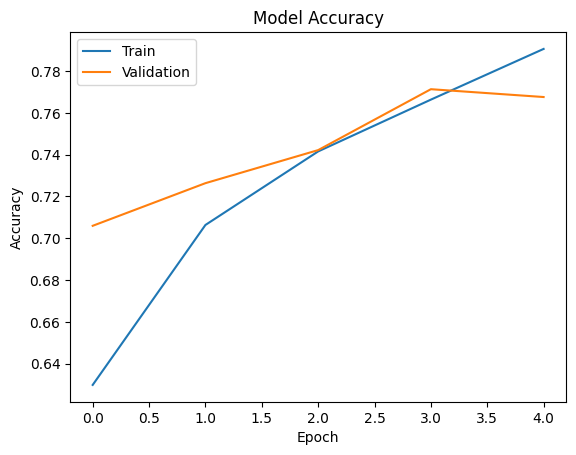

In [ ]:
# Plot the training and validation accuracy over time
train_acc = bi_lstm_history.history['accuracy']
val_acc = bi_lstm_history.history['val_accuracy']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

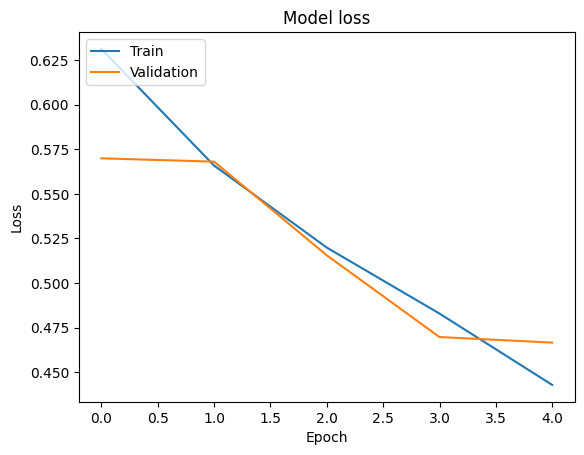

In [ ]:
# Plot the training and validation accuracy over time
train_acc = bi_lstm_history.history['loss']
val_acc = bi_lstm_history.history['val_loss']

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Assume X_test is the test data and y_test is the corresponding labels
y_pred = bi_lstm_model.predict(xvalid_pad)

y_pred = np.round(y_pred) # Convert probabilities to class labels

accuracy = accuracy_score(yvalid, y_pred)
precision = precision_score(yvalid, y_pred, average='weighted')
recall = recall_score(yvalid, y_pred, average='weighted')
f1 = f1_score(yvalid, y_pred, average='weighted')
auc_score = roc_auc_score(yvalid, y_pred,average='weighted')
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("AUC score: ", auc_score)

76/76 [==============================] - 26s 339ms/step
Accuracy:  0.7675968346522283
Precision:  0.7758165465132211
Recall:  0.7675968346522283
F1 Score:  0.7634873718008598
AUC score:  0.7594224907058013


In [ ]:
scores_bi_lstm = bi_lstm_model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_bi_lstm,yvalid)))

76/76 [==============================] - 26s 340ms/step
Auc: 0.87%


In [ ]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores_bi_lstm,yvalid)})

In [ ]:
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.8152350951173732},
 {'Model': 'LSTM', 'AUC_Score': 0.8799828200258257},
 {'Model': 'LSTM', 'AUC_Score': 0.8799828200258257},
 {'Model': 'GRU', 'AUC_Score': 0.8741127631032164},
 {'Model': 'Bi-directional LSTM', 'AUC_Score': 0.8682064497416031}]